# CycleGAN: toy example
This is an toy example that demonstrates CycleGAN.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import itertools

import matplotlib.pyplot as plt

### Functions for generation and visualization of the image batches

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    grid = make_grid(batch, nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def random_image_data(size=(2**21, 3, 1, 1), ratio=0.5, offset=0.2, color=0):
    '''Generates a random image batch 
    consisting of two modes (dark and light images)
    
    Parameters:
    size (tuple): The dimensions of the image batch (batch_size, channels, width, length)
    ratio (float): The ratio of light to dark images
    offset (float): The brightness of the images relative to black and bright
    color (int): Red = 0, green = 1, blue = 2
    
    Returns:
    image_batch (Tensor): The generated image batch
    
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])] # Randomly choose indices according to the ratio
    image_batch = torch.zeros(size)
    image_batch[:, color] += offset # light color
    image_batch[idx, color] = 1 - offset # dark color 
    return image_batch

### The dataset class

In [4]:
class ColorDataset(Dataset):
    '''The dataloader for the color images
    '''
    def __init__(self, ratio=0.5, offset=0.2, color=0):
        '''  
        Parameters:
        ratio (float): The ratio of light to dark images
        offset (float): The brightness of the images relative to black and bright
        color (int): Red = 0, green = 1, blue = 2
        '''
        self.offset = offset
        self.ratio = ratio
        self.color = color
        
        self.dataset = random_image_data(ratio=self.ratio, 
                                         offset=self.offset, 
                                         color=self.color)
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each mode in the domain
        
        '''
        example_imgs = torch.zeros(size=(2, 3, 1, 1))

        example_imgs[0, self.color] += self.offset # light color
        example_imgs[1, self.color] = 1 - self.offset # dark color
        return example_imgs   

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

### The networks

In [5]:
class Discriminator(nn.Module):
    '''A simple joint discriminator network'''

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out

In [6]:
class Generator(nn.Module):
    '''A simple conditional generator network'''

    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out.unsqueeze(-1).unsqueeze(-1)

### A demonstration of the two domains
The idea here is that we create two domains: A red and a green domain. The domains consist of two modes: dark and light images. The big assumption here for our purpose is that the dark and light images have semantic correspondance, so for example: dark red will be translated to dark green.

We can adjust the intensity of the images (offset) and the ratio of the modes for the experiment. In the visualiztion you can see the elements of the dataset. In the histogram you can see the modes.

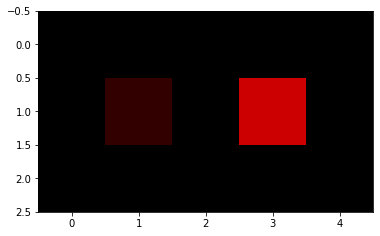

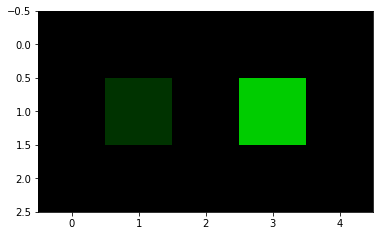

In [23]:
# Settings for domain A (red)
offset_A = 0.2
ratio_A = 0.5
color_A = 0
dataset_A = ColorDataset(offset=offset_A, ratio=ratio_A, color=color_A)
dataloader_A = DataLoader(dataset_A, batch_size=256, shuffle=True)

# Settings for domain B (green)
offset_B = 0.2
ratio_B = 0.5
color_B = 1
dataset_B = ColorDataset(offset=offset_B, ratio=ratio_B, color=color_B)
dataloader_B = DataLoader(dataset_B, batch_size=256, shuffle=True)

visualize_img_batch(dataset_A.example_imgs)
visualize_img_batch(dataset_B.example_imgs)

True ratio domain A: 0.5
Count: tensor([138, 118]) Ratio in this batch: tensor([0.5391, 0.4609])


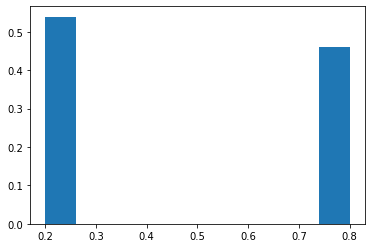

True ratio domain B: 0.5
Count: tensor([120, 136]) Ratio in this batch: tensor([0.4688, 0.5312])


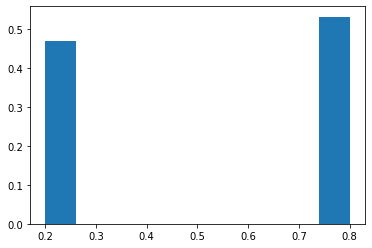

In [24]:
def plot_hist(data):
    data = data.view(3, -1).sum(0)
    plt.hist(data, weights=torch.ones(len(data))/len(data))
    x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    
    print('Count:', x_unique_count, 'Ratio in this batch:', x_unique_count/float(x_unique_count.sum()))

    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
    print('True ratio domain A:', dataloader_A.dataset.ratio)
    plot_hist(data_A)
    print('True ratio domain B:', dataloader_B.dataset.ratio)
    plot_hist(data_B)
    break

## The training loop

In [25]:
# Initialize the networks
generator_A = Generator()
generator_B = Generator()
discriminator_A = Discriminator()
discriminator_B = Discriminator()

# Initialize the optimizers
optimizer_g = optim.Adam(itertools.chain(generator_A.parameters(),
                                         generator_B.parameters()), lr=0.01)
optimizer_d = optim.Adam(itertools.chain(discriminator_A.parameters(),
                                         discriminator_B.parameters()), lr=0.01)

# Store values
samples_A = []
samples_B = []

losses_g = []
losses_d = []

criterion_D = nn.MSELoss()
criterion_G = nn.MSELoss()
criterion_cycle = nn.MSELoss()
criterion_L2 = nn.MSELoss()

for epoch in range(1):
    for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):
        # Set gradients to zero
        optimizer_d.zero_grad()
        optimizer_g.zero_grad()

        # Forward
        fake_A = generator_A(real_B)
        fake_B = generator_B(real_A)
        
        rec_A = generator_A(fake_B)
        rec_B = generator_B(fake_A)
        
        pred_real_A = discriminator_A(real_A)
        pred_real_B = discriminator_B(real_B)
        
        pred_fake_A = discriminator_A(fake_A.detach())
        pred_fake_B = discriminator_B(fake_B.detach())
        
        # The loss function --------------------------------------------------------------------------------
        loss_D_real_A = criterion_D(pred_real_A, torch.ones((pred_real_A.shape)))
        loss_D_real_B = criterion_D(pred_real_B, torch.ones((pred_real_B.shape)))

        loss_D_fake_A = criterion_D(pred_fake_A, torch.zeros((pred_fake_A.shape)))
        loss_D_fake_B = criterion_D(pred_fake_B, torch.zeros((pred_fake_B.shape)))
        
        loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
        loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
        
        loss_G_A = criterion_G(discriminator_A(fake_A), torch.ones((pred_fake_A.shape)))
        loss_G_B = criterion_G(discriminator_B(fake_B), torch.ones((pred_fake_A.shape)))
        
        cycle_A = criterion_cycle(real_A, rec_A)
        cycle_B = criterion_cycle(real_B, rec_B)
        cycle = cycle_A + cycle_B
        
        loss_d = (loss_D_A + loss_D_B)
        loss_g = (loss_G_A + loss_G_B) + cycle
        # ---------------------------------------------------------------------------------------------------

        # Backward
        loss_g.backward()
        loss_d.backward()

        # Optimization step
        optimizer_g.step()
        optimizer_d.step()

        # Store values --------------------------------------------------------------------------------------
        losses_g += [loss_g.item()]
        losses_d += [loss_d.item()]
        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            samples_A += [fake_A.detach()]
            samples_B += [fake_B.detach()]
            print('step', i, 'loss_g', loss_g.item(), 'loss_d', loss_d.item())

step 0 loss_g 0.8978154063224792 loss_d 0.5144343376159668
step 500 loss_g 0.18384495377540588 loss_d 0.624800443649292
step 1000 loss_g 0.12538737058639526 loss_d 0.6247423887252808
step 1500 loss_g 0.12483381479978561 loss_d 0.6251763105392456
step 2000 loss_g 0.12507660686969757 loss_d 0.6249189376831055
step 2500 loss_g 0.12494678050279617 loss_d 0.6250402927398682
step 3000 loss_g 0.12528617680072784 loss_d 0.6253941655158997
step 3500 loss_g 0.12499190866947174 loss_d 0.6250513792037964
step 4000 loss_g 0.12500952184200287 loss_d 0.6249685287475586
step 4500 loss_g 0.12490196526050568 loss_d 0.6251013278961182
step 5000 loss_g 0.12497147917747498 loss_d 0.6251363158226013
step 5500 loss_g 0.12499032914638519 loss_d 0.6250202059745789
step 6000 loss_g 0.12497780472040176 loss_d 0.6250240206718445
step 6500 loss_g 0.125015527009964 loss_d 0.6249862909317017
step 7000 loss_g 0.12498277425765991 loss_d 0.6250185966491699
step 7500 loss_g 0.1250104010105133 loss_d 0.6249825954437256
s

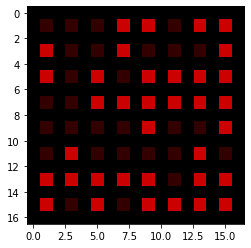

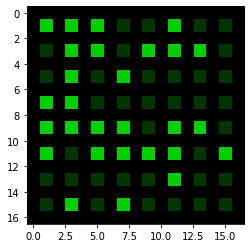

Count: tensor([39, 31, 31, 35, 43, 23, 23, 31]) Ratio in this batch: tensor([0.1523, 0.1211, 0.1211, 0.1367, 0.1680, 0.0898, 0.0898, 0.1211])


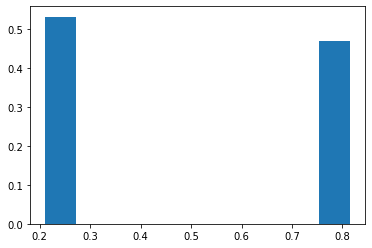

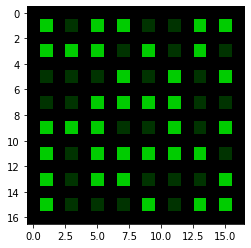

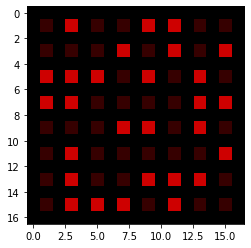

Count: tensor([36, 28, 37,  9, 24, 37, 33, 24, 28]) Ratio in this batch: tensor([0.1406, 0.1094, 0.1445, 0.0352, 0.0938, 0.1445, 0.1289, 0.0938, 0.1094])


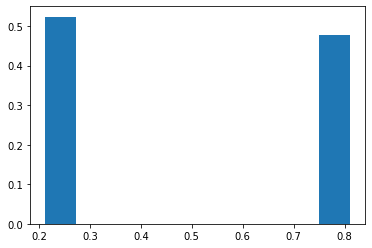

In [26]:
# Some generated images
visualize_img_batch(real_A.detach()[:64])
visualize_img_batch(fake_B.detach()[:64])
plot_hist(fake_B.detach())

visualize_img_batch(real_B.detach()[:64])
visualize_img_batch(fake_A.detach()[:64])
plot_hist(fake_A.detach())

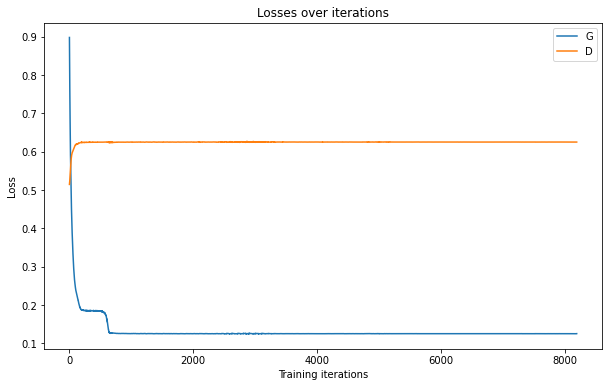

In [27]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(losses_g)
plt.plot(losses_d)
plt.legend(['G', 'D'])
plt.show()

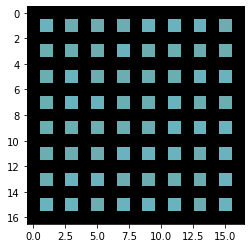

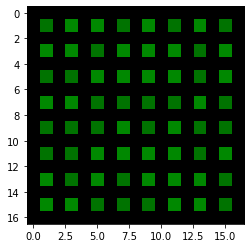

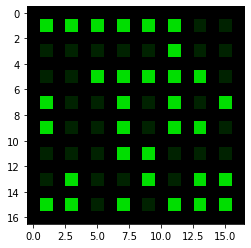

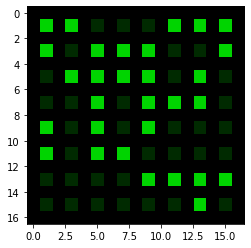

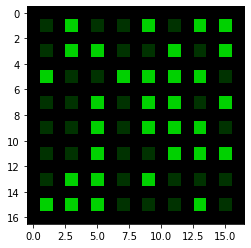

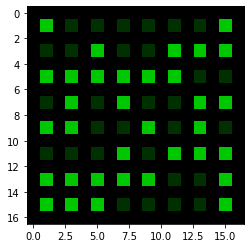

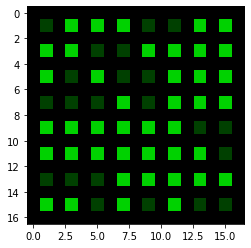

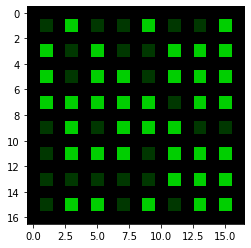

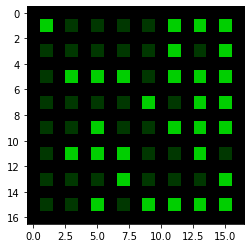

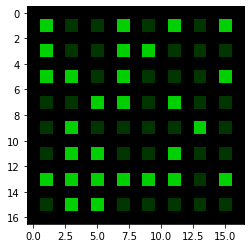

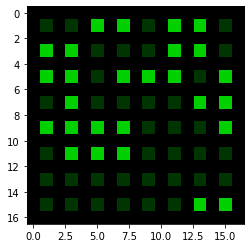

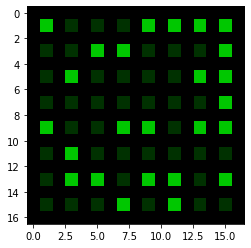

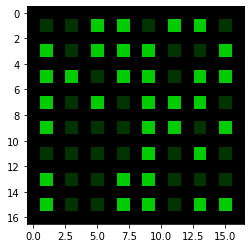

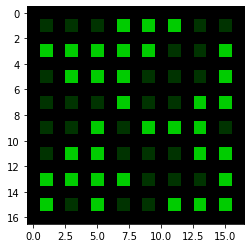

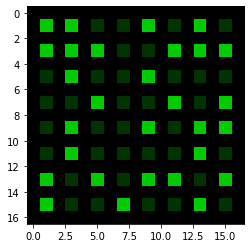

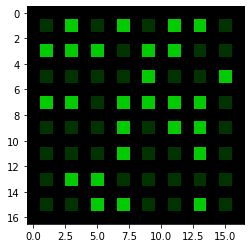

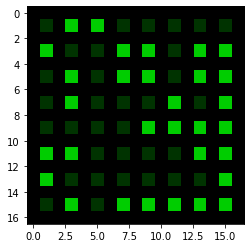

In [28]:
for img in samples_B:
    visualize_img_batch(img[:64])